In [23]:
from kafka import KafkaConsumer
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
import pickle

# Open the pickled model file for reading ('rb' mode)
with open('your_model.pkl', 'rb') as model_file:
    RFC = pickle.load(model_file)

In [18]:
from kafka import KafkaConsumer
import pandas as pd
from io import StringIO

def df_from_bytes(bytes_data, column_names):
    str_data = str(bytes_data.value, 'utf-8')
    str_data_new = str_data.replace('"', '').replace('\\n', '')
    data = StringIO(str_data_new)
    data_df = pd.read_csv(data, names=column_names, sep=",")
    return data_df

In [19]:
feature_selection = ['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'special', 'labels', 'len', 'len_longest_word', 'len_sld']

In [30]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)


it = iter(consumer)
column_names = next(it).value.decode().replace('\\u00ef\\u00bb\\u00bf','').replace('"','').replace('\\n','').split(',')

df = pd.DataFrame(columns=column_names)
temp_df = pd.DataFrame()
batch = 0
train_times = 0
overall_f1_score = []
overall_precision = []
overall_recall = []
for i,consumer_data in enumerate(consumer):
    if i%1000 != 0 or i == 0:
        
        # creating the dataframe with 1000 rows
        
        data_df = df_from_bytes(consumer_data,column_names)
        temp_df = pd.concat([data_df, temp_df], ignore_index=True)
    else:
        batch += 1
        final_df = pd.concat([df, temp_df], ignore_index=True)
        final_df = final_df.dropna(how="any") # drop rows with any missing values

        final_df['len_longest_word'] = final_df['longest_word'].apply(lambda x: len(str(x))) #feature engineering
        final_df['len_sld'] = final_df['sld'].apply(lambda x: len(str(x)))
        test_x = final_df.loc[:, feature_selection]
        test_y = final_df['Target Attack']

        pred_y = RFC.predict(test_x)
        test_y = test_y.astype("int64")
        pred_f1_score = f1_score(test_y, pred_y)
        pred_precision = precision_score(test_y, pred_y)
        pred_recall = recall_score(test_y, pred_y)
        print("f1_score of batch {} = {}".format(batch, pred_f1_score))

        if pred_f1_score <= 0.85:
            RFC.fit(test_x, test_y)
            train_times += 1
            print("number of time trained:", train_times)

        overall_f1_score.append(pred_f1_score)
        overall_precision.append(pred_precision)
        overall_recall.append(pred_recall)
        

        final_df = pd.DataFrame()
        temp_df = pd.DataFrame()
        
        if batch == 268:
            break
        


f1_score of batch 1 = 0.8419354838709677
number of time trained: 1
f1_score of batch 2 = 0.8485329103885805
number of time trained: 2
f1_score of batch 3 = 0.8403100775193798
number of time trained: 3
f1_score of batch 4 = 0.858905165767155
f1_score of batch 5 = 0.8403225806451613
number of time trained: 4
f1_score of batch 6 = 0.852559205500382
f1_score of batch 7 = 0.846930846930847
number of time trained: 5
f1_score of batch 8 = 0.8467492260061921
number of time trained: 6
f1_score of batch 9 = 0.8579970104633782
f1_score of batch 10 = 0.8659003831417624
f1_score of batch 11 = 0.8571428571428571
f1_score of batch 12 = 0.8578088578088578
f1_score of batch 13 = 0.8491008600469117
number of time trained: 7
f1_score of batch 14 = 0.8400315208825847
number of time trained: 8
f1_score of batch 15 = 0.8586872586872586
f1_score of batch 16 = 0.853125
f1_score of batch 17 = 0.8377952755905511
number of time trained: 9
f1_score of batch 18 = 0.8334648776637726
number of time trained: 10
f1_sc

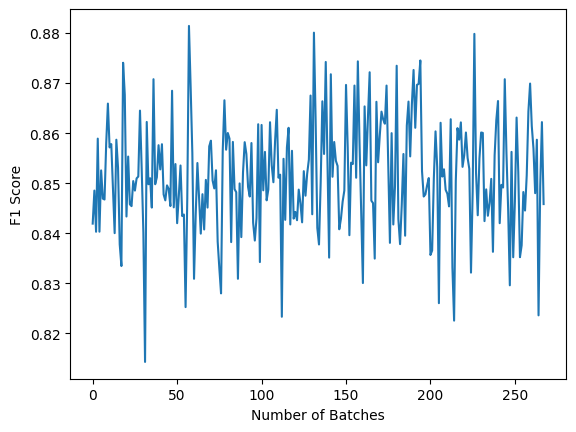

In [34]:
from matplotlib import pyplot as plt
plt.plot(overall_f1_score)
plt.xlabel('Number of Batches')
plt.ylabel('F1 Score')
plt.show()

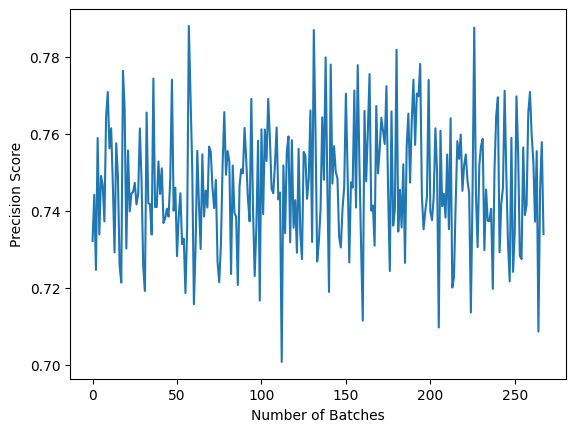

In [33]:
plt.plot(overall_precision)
plt.xlabel('Number of Batches')
plt.ylabel('Precision Score')
plt.show()

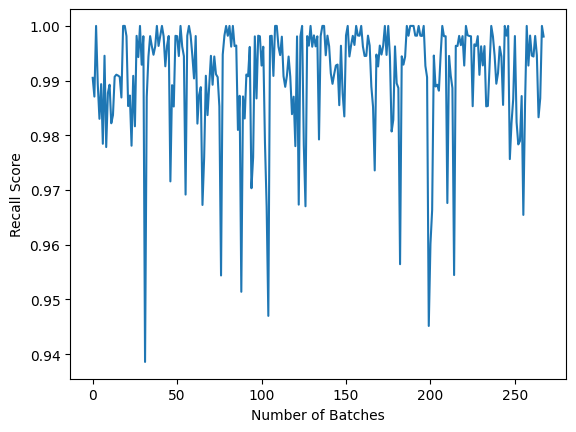

In [35]:
plt.plot(overall_recall)
plt.xlabel('Number of Batches')
plt.ylabel('Recall Score')
plt.show()